In [0]:
!pip install ortools

In [0]:
import ortools
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [0]:
def create_data_model():
  """Stores the data for the problem."""
  data = {}
  data['time_matrix'] = [
      [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
      [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
      [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
      [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
      [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
      [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
      [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
      [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
      [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
      [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
      [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
      [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
      [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
      [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
      [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
      [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
      [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
  ]
  data['time_windows'] = [
      (0, 5),  # depot
      (7, 12),  # 1
      (10, 15),  # 2
      (16, 18),  # 3
      (10, 13),  # 4
      (0, 5),  # 5
      (5, 10),  # 6
      (0, 4),  # 7
      (5, 10),  # 8
      (0, 3),  # 9
      (10, 16),  # 10
      (10, 15),  # 11
      (0, 5),  # 12
      (5, 10),  # 13
      (7, 8),  # 14
      (10, 15),  # 15
      (11, 15),  # 16
  ]

  data['num_vehicles'] = 9

  data['demands'] = [0, 1, 1, 2, 4, 2, 5 , 8, 8, 1, 2, 1, 2, 4, 4, 8, 0]

  data['vehicle_capacities'] = [14, 12, 16, 12, 15, 20,12,14,20]
  data['min_capacity'] = [int(0.85*data['vehicle_capacities'][i]) for i in range(data['num_vehicles'])]
  data['depot'] = 0
  #data['starts'] = [0]*data['num_vehicles']
  #data['ends'] = [16]*data['num_vehicles']
  
  return data

data = create_data_model()



In [0]:
len(data['time_matrix'])
len(data['demands'])

17

In [0]:
def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    print("objective cost: ", assignment.ObjectiveValue())
    print()
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    total_load = 0
    all_vehicles = []

    for vehicle_id in range(data['num_vehicles']):
        each_vehicle = []
        vehicle_load = 0
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {0} with min_capacity:{1}: and max_capacity = {2}\n'.format(vehicle_id, data['min_capacity'][vehicle_id],data['vehicle_capacities'][vehicle_id])

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            each_vehicle.append(node_index)

            vehicle_load += data['demands'][node_index]
            time_var = time_dimension.CumulVar(index)
            plan_output += 'Node:{0},Time(mintime: {1}, maxtime: {2}),load:{3} -> '.format(manager.IndexToNode(index), assignment.Min(time_var), assignment.Max(time_var), vehicle_load)
            index = assignment.Value(routing.NextVar(index))

        time_var = time_dimension.CumulVar(index)

        plan_output += 'Node:{0},Time(mintime: {1}, maxtime: {2}),load:{3} -> '.format(manager.IndexToNode(index), assignment.Min(time_var), assignment.Max(time_var), vehicle_load)
        plan_output += 'Time of the route: {}min\n'.format (assignment.Min(time_var))
        
        if vehicle_load !=0:
          print(plan_output)
          each_vehicle.append(manager.IndexToNode(index))
          all_vehicles.append(each_vehicle)

        total_time += assignment.Min(time_var)
        total_load += vehicle_load
    
    print('Total time of all routes: {}min'.format(total_time))
    print("total demand satisfied ", total_load)
    return all_vehicles
 

In [0]:
def main(guide_time  = 30, local_search = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH):
    """Solve the VRP with time windows."""
    data = create_data_model()

    ############# Manager ##########################################################################
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']), data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    ##################    Amortized cost ###########################################################
    #routing.SetAmortizedCostFactorsOfAllVehicles(linear_cost_factor= 10*6, quadratic_cost_factor=1)

    
    ################ Time Constraint   #############################################################
    
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    time = 'Time'
    
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        100,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)

    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add time window constraints for each vehicle start node.
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0], data['time_windows'][0][1])

    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))
        
    ################################################################################################
        

    ###################### Capacity Constraint #####################################################


    capacity_dim = 'capacity'
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    
    routing.AddDimensionWithVehicleCapacity(demand_callback_index,0, data['vehicle_capacities'], True,capacity_dim)
    
     ####### min capactity
    capacity_dimension = routing.GetDimensionOrDie(capacity_dim)
    minimum_allowed_capacity = data['min_capacity']
    for vehicle in range(data['num_vehicles']):
         capacity_dimension.CumulVar(routing.End(vehicle)).RemoveInterval(1, minimum_allowed_capacity[vehicle])

    ################################################################################################


    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (local_search)
    search_parameters.time_limit.seconds = guide_time

    assignment = routing.SolveWithParameters(search_parameters)

    if assignment:
       all_vehicles =  print_solution(data, manager, routing, assignment)

    return data, manager, routing, assignment, all_vehicles

# data, manager, routing, assignment,all_vehicles = main()

In [0]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def plot(plot_values):
    n= len(plot_values)
    cmap = get_cmap(len(data))
    for i in range(n):
        bus_i_route = plot_values[i].copy()
        if len(plot_values[i]) != 1:
            plt.figure(figsize = [10,4])
            plt.title("route taken by bus" + str(i) + "is" + str(bus_i_route))

            X = bus_i_route[:-1]
            Y = bus_i_route[1:]

            plt.plot(X,Y, c = cmap(i))
            for a,b in zip(X,Y): 
              plt.text(a, b, str(a), fontsize=15)
    plt.show()
    
plot(all_vehicles)

## Different options we have for local search in minima
- AUTOMATIC  

```
routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
```


- GREEDY_DESCENT
- GUIDED_LOCAL_SEARCH
- SIMULATED_ANNEALING	
- TABU_SEARCH
- OBJECTIVE_TABU_SEARCH 





## 1. Results: GUIDED_LOCAL_SEARCH Keeping guide time  = 300

objective cost:  71

Route for vehicle 2 with min_capacity:13: and max_capacity = 16
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:12,Time(mintime: 4, maxtime: 4),load:2 -> Node:13,Time(mintime: 6, maxtime: 6),load:6 -> Node:15,Time(mintime: 11, maxtime: 11),load:14 -> Node:11,Time(mintime: 14, maxtime: 14),load:15 -> Node:0,Time(mintime: 20, maxtime: 20),load:15 -> Time of the route: 20min

Route for vehicle 4 with min_capacity:12: and max_capacity = 15
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:7,Time(mintime: 2, maxtime: 4),load:8 -> Node:1,Time(mintime: 7, maxtime: 11),load:9 -> Node:4,Time(mintime: 10, maxtime: 13),load:13 -> Node:3,Time(mintime: 16, maxtime: 16),load:15 -> Node:0,Time(mintime: 24, maxtime: 24),load:15 -> Time of the route: 24min

Route for vehicle 6 with min_capacity:10: and max_capacity = 12
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:9,Time(mintime: 2, maxtime: 3),load:1 -> Node:5,Time(mintime: 4, maxtime: 5),load:3 -> Node:6,Time(mintime: 6

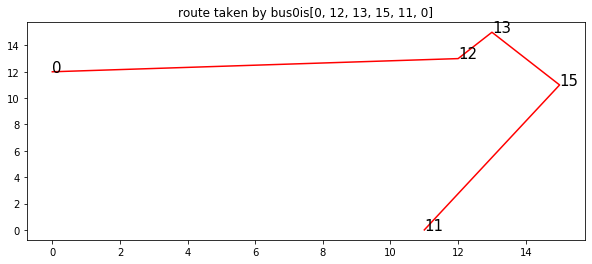

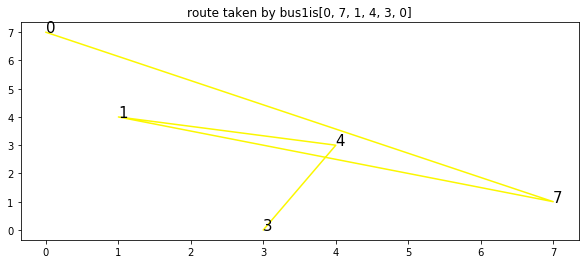

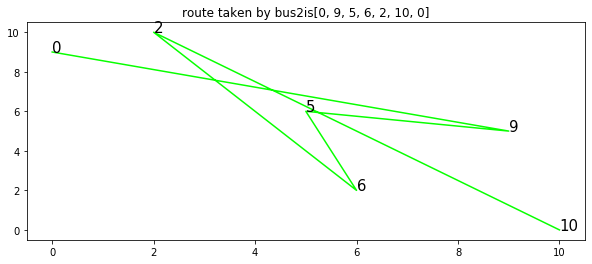

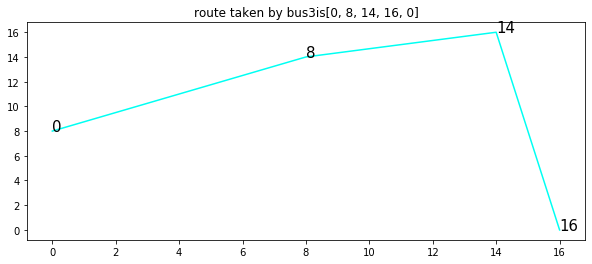

In [0]:
#1 guide time = 300
# this cell was run before and so by running it again will not produce the result
#to run this with guided local search, uncomment the following lines and commend out the uncommented.

#data2, manager2, routing2, assignment2,all_vehicles2 = main(guide_time = 180, local_search= routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
#plot(all_vehicles2)

print_solution(data, manager, routing, assignment)
plot(all_vehicles)


## USING TABU_SEARCH
`routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH`




objective cost:  71

Route for vehicle 2 with min_capacity:13: and max_capacity = 16
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:7,Time(mintime: 2, maxtime: 4),load:8 -> Node:1,Time(mintime: 7, maxtime: 11),load:9 -> Node:4,Time(mintime: 10, maxtime: 13),load:13 -> Node:3,Time(mintime: 16, maxtime: 16),load:15 -> Node:0,Time(mintime: 24, maxtime: 24),load:15 -> Time of the route: 24min

Route for vehicle 4 with min_capacity:12: and max_capacity = 15
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:12,Time(mintime: 4, maxtime: 4),load:2 -> Node:13,Time(mintime: 6, maxtime: 6),load:6 -> Node:15,Time(mintime: 11, maxtime: 11),load:14 -> Node:11,Time(mintime: 14, maxtime: 14),load:15 -> Node:0,Time(mintime: 20, maxtime: 20),load:15 -> Time of the route: 20min

Route for vehicle 6 with min_capacity:10: and max_capacity = 12
Node:0,Time(mintime: 0, maxtime: 0),load:0 -> Node:9,Time(mintime: 2, maxtime: 3),load:1 -> Node:5,Time(mintime: 4, maxtime: 5),load:3 -> Node:6,Time(mintime: 6

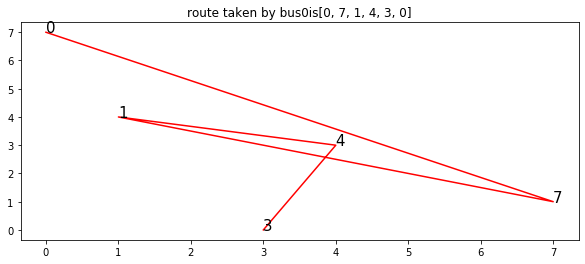

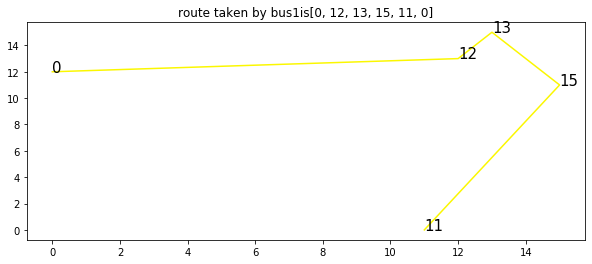

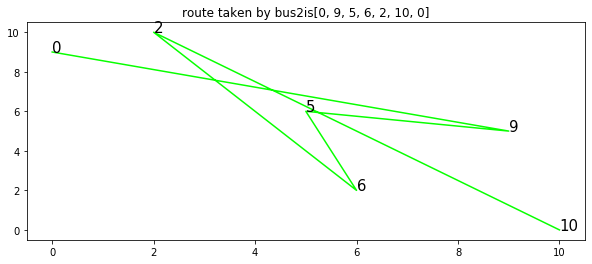

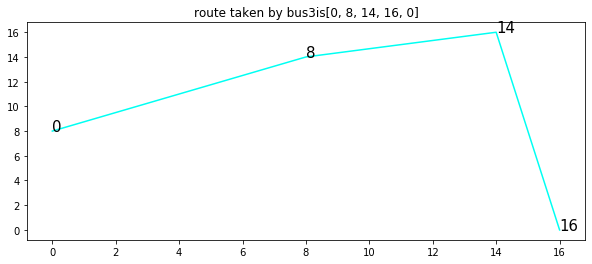

In [0]:
data2, manager2, routing2, assignment2,all_vehicles2 = main(guide_time = 180, local_search= routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
plot(all_vehicles2)